In [34]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import json

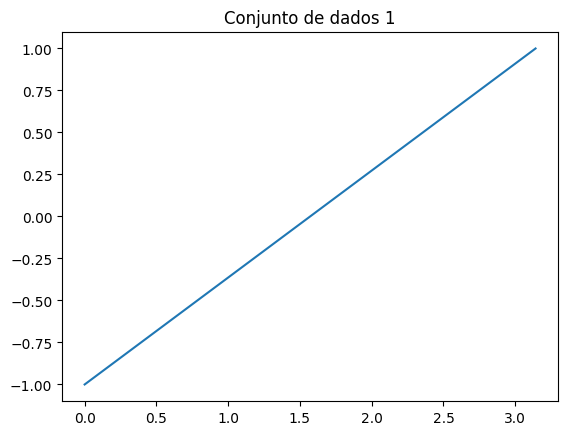

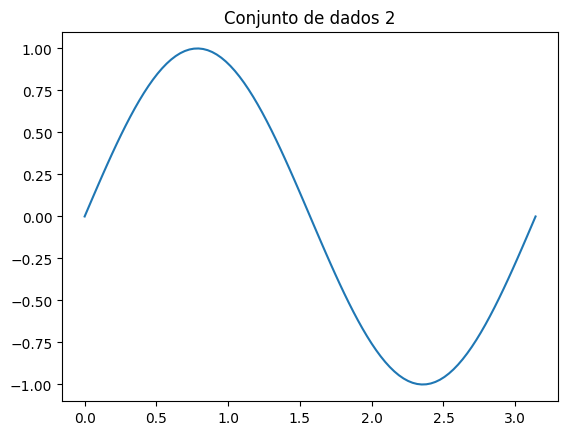

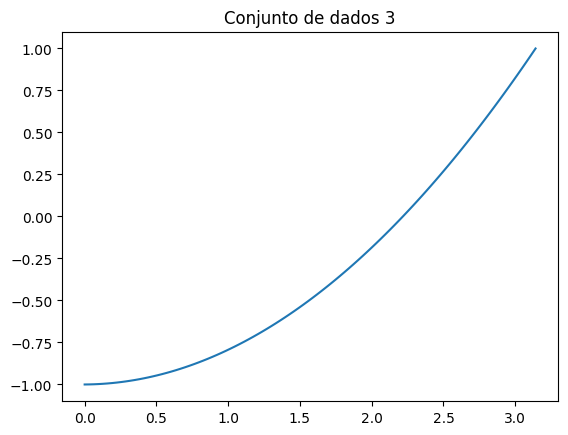

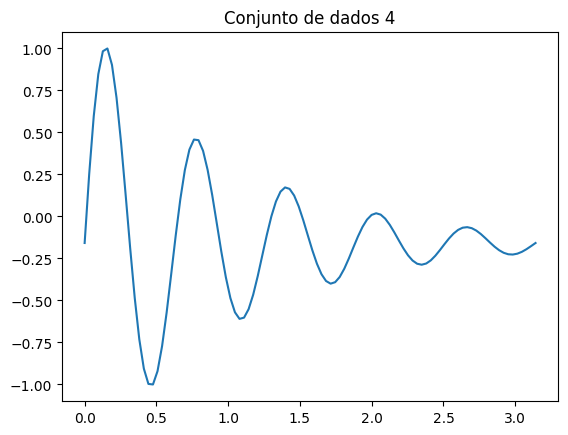

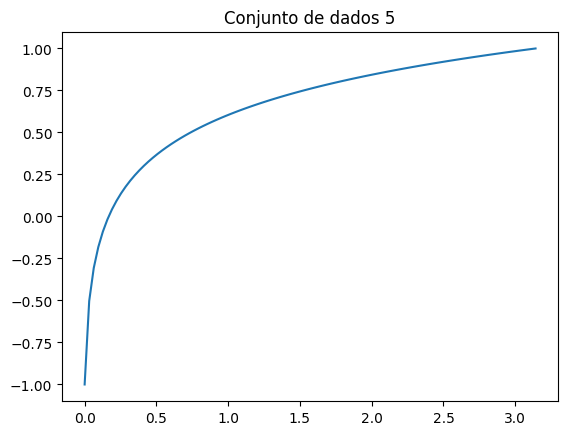

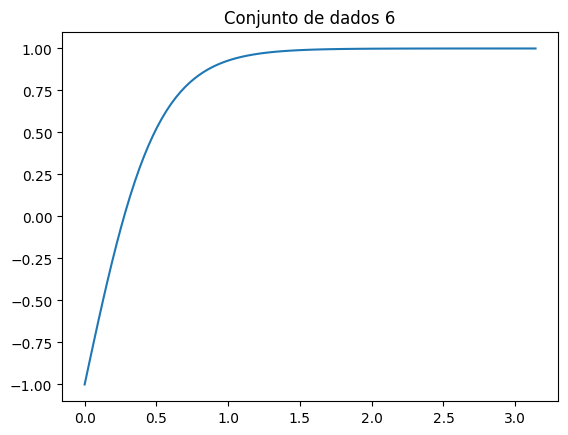

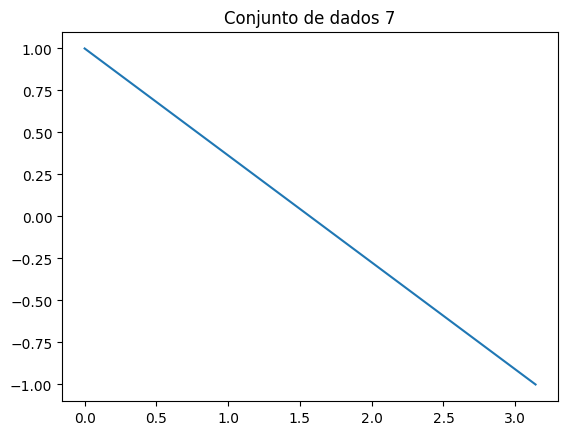

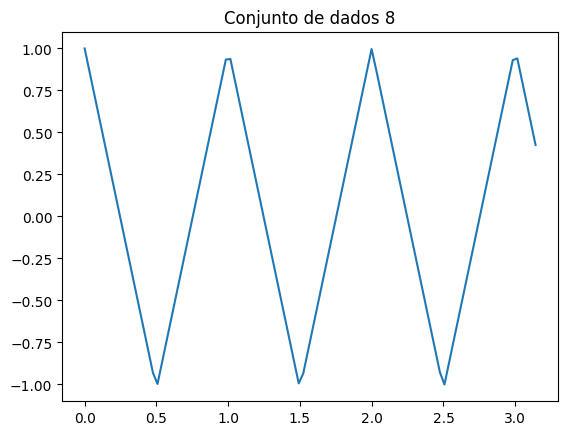

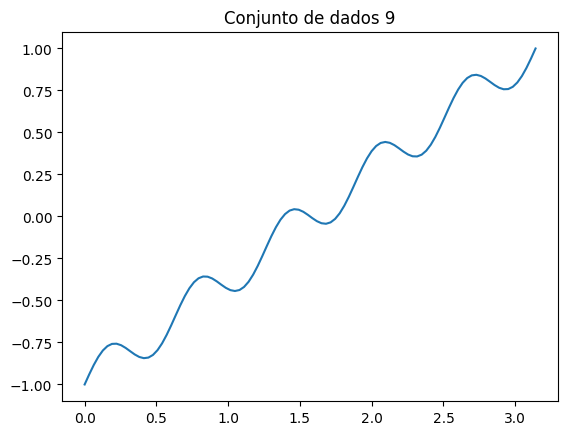

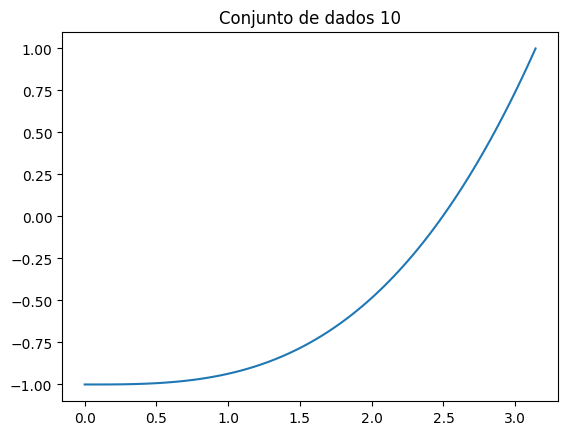

In [13]:
funcs = {
    0: lambda x: 2 * x + 1, # Linearidade simples
    1: lambda x: np.sin(x / 50), # Periodicidade
    2: lambda x: x**2 + 3 * x + 2, # Não linear com tendência crescente
    3: lambda x: np.exp(-x / 100) * np.sin(x / 10),  # damped sine wave
    4: lambda x: np.log1p(np.abs(x)),               # log-based growth
    5: lambda x: np.tanh(x / 50),                   # sigmoid-like nonlinearity
    6: lambda x: np.piecewise(x, [x < 0, x >= 0], [lambda x: x**2, lambda x: -x]),  # piecewise
    7: lambda x: np.abs(x % 100 - 50),              # triangular wave
    8: lambda x: 10 * np.sin(x / 10) + 0.5 * x,     # trend + periodicity
    9: lambda x: (x / 10)**3 - (x / 10),            # cubic polynomial
}

def min_max_norm(dataset):
    norm_dataset = {}
    X = dataset["x"] 
    Y = dataset["y"] 

    norm_dataset["x"] = ((X - np.min(X)) / (np.max(X) - np.min(X))) *np.pi
    norm_dataset["y"] = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) *2 -1

    return norm_dataset

def generate_dataset(func, x_min=0, x_max=100 * np.pi, num_samples=100):

    X = np.linspace(x_min, x_max, num_samples)
    y = func(X)
    return X, y

datasets = {}

for i in funcs:
    x, y = generate_dataset(funcs[i])
    datasets[i] = {}
    datasets[i]["x"] = x
    datasets[i]["y"] = y

    datasets[i] = min_max_norm(datasets[i])

for i in datasets:
    plt.title(f"Conjunto de dados {i+1}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

In [29]:
class QuantumRegressor(object):
    def __init__(self, n_qubits=1, n_layers=3):
        """
        Initialize the QuantumRegressor.

        Inputs:
            n_qubits (int): Number of qubits to use in the quantum circuit.
            n_layers (int): Number of layers in the quantum circuit.

        Outputs:
            None
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.device = qml.device('default.qubit', wires=self.n_qubits)
        self.embedding_device = qml.device('default.qubit', wires=self.n_qubits)
        self.training_time = None
        self.circuit_depth = self._calculate_circuit_depth()
        self.training_time = -1
        self.embedding_time = -1
        self.qaoa_weights = None

        if self.n_qubits > 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.n_layers, n_wires=self.n_qubits)
            self.parameters = 0.01 * np.random.randn(*shape, requires_grad=True)
        else:
            self.parameters = 0.01 * np.random.randn(self.n_layers, 3, requires_grad=True)

        self.bias = np.array(0.0, requires_grad=True)


        @qml.qnode(self.embedding_device)
        def qaoa_circuit(weights, features):
            qml.QAOAEmbedding(features = features, weights = weights, wires = range(self.n_qubits), local_field='Y')
            return qml.expval(qml.PauliZ(0))
        self.qaoa_emb = qaoa_circuit    
        
            
        @qml.qnode(self.device)
        def quantum_circuit(params, x_input):
            """
            Quantum circuit for regression.

            Inputs:
                params (np.ndarray): Parameters for the quantum gates.
                x_input (np.ndarray): Input features, should have length equal to n_qubits.

            Outputs:
                float: Expectation value of PauliZ on wire 0.
            """
            if len(x_input) != self.n_qubits:
                raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
            
            # Embedding!
            
            features = np.array(x_input)
            if self.qaoa_weights is None:
                raise Exception("É necessário treinar o embedding antes")
            qml.QAOAEmbedding(features = features, weights = self.qaoa_weights, wires=range(self.n_qubits), local_field='Y')
            
            
            if self.n_qubits > 1:
                qml.StronglyEntanglingLayers(weights=params, wires=range(self.n_qubits))
            else:
                for i in range(self.n_layers):
                    qml.Rot(*params[i], wires=0)
            return qml.expval(qml.PauliZ(0))
        self.qnode = quantum_circuit

        
    def _calculate_circuit_depth(self):
        """
        Calculate the depth of the quantum circuit.

        Inputs:
            None

        Outputs:
            int: The depth of the quantum circuit.
        """
        embedding_depth = 1
        if self.n_qubits > 1:
            processing_depth = self.n_layers * 2
        else:
            processing_depth = self.n_layers
        return embedding_depth + processing_depth

    @staticmethod
    def loss_fn(y_true, y_pred):
        """
        Compute the mean absolute error loss.

        Inputs:
            y_true (np.ndarray): True target values.
            y_pred (np.ndarray or list): Predicted values.

        Outputs:
            float: Mean absolute error between y_true and y_pred.
        """
        return np.mean(np.abs(y_true - y_pred))

    def compute_loss(self, X, y, params=None, bias=None):
        """
        Compute the loss for a given dataset and parameters.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Computed loss value.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if X.shape[1] > self.n_qubits:
            raise ValueError(f"Input features must have less than {self.n_qubits} columns, got {X.shape[1]}")
        y_pred = np.array([self.qnode(params, x) + bias for x in X])
        return self.loss_fn(y, y_pred)

    def forward(self, x_input, params=None, bias=None):
        """
        Perform a forward pass through the quantum circuit.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Predicted value for the input.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if len(x_input) != self.n_qubits:
            raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
        return self.qnode(params, x_input) + bias

    def predict_single(self, x_input):
        """
        Predict the output for a single input value.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.

        Outputs:
            float: Predicted value for the input.
        """
        return self.forward(x_input)

    def plot_circuit(self, expand_layers=True):
        """
        Plot the quantum circuit using matplotlib.

        Inputs:
            expand_layers (bool): If True, expands the StronglyEntanglingLayers to show individual gates.
                                  If False, shows the compact representation.

        Outputs:
            None
        """
        features = np.ones(self.n_qubits)
        if expand_layers:
            @qml.qnode(self.device)
            def expanded_circuit(params, x_input):
                features = np.array(x_input)
                shape = qml.QAOAEmbedding.shape(n_layers = self.n_layers, n_wires = self.n_qubits)
                weights = np.random.random(shape)
                qml.QAOAEmbedding(features=features, weights = weights, wires=range(self.n_qubits), local_field='Y')
                if self.n_qubits > 1:
                    for layer in range(self.n_layers):
                        for wire in range(self.n_qubits):
                            qml.Rot(*params[layer, wire, :3], wires=wire)
                        for wire in range(self.n_qubits - 1):
                            qml.CNOT(wires=[wire, wire + 1])
                        if self.n_qubits > 2:
                            qml.CNOT(wires=[self.n_qubits - 1, 0])
                else:
                    for i in range(self.n_layers):
                        qml.Rot(*params[i], wires=0)
                return qml.expval(qml.PauliZ(0))
            fig, ax = qml.draw_mpl(expanded_circuit)(self.parameters, features)
        else:
            fig, ax = qml.draw_mpl(self.qnode)(self.parameters, features)
        plt.show()

    def predict(self, X):
        """
        Predict outputs for multiple input samples.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).

        Outputs:
            list: List of predicted values for each input sample.
        """
        if X.shape[1] > self.n_qubits:
            raise ValueError(f"Input features must have less than {self.n_qubits} columns, got {X.shape[1]}")
        return [self.forward(x) for x in X]

    def batch_loss(self, params, bias, X_batch, y_batch):
        """
        Compute the loss for a batch of data.

        Inputs:
            params (np.ndarray): Parameters for the quantum circuit.
            bias (np.ndarray): Bias term.
            X_batch (np.ndarray): Batch of input features.
            y_batch (np.ndarray): Batch of target values.

        Outputs:
            float: Computed loss value for the batch.
        """
        return self.compute_loss(X_batch, y_batch, params, bias)

    def qaoa_loss(self, weights, features):
        return np.sum([self.qaoa_emb(weights, x) for x in features])
    
    def qaoa_embedding_fit(self, features, epochs=70, learning_rate=0.01):
        shape = qml.QAOAEmbedding.shape(n_layers = self.n_layers, n_wires = self.n_qubits)
        weights = np.random.random(shape)
        
        opt = qml.GradientDescentOptimizer(learning_rate)
        start_time = time.time()
        for i in tqdm(range(epochs),desc=f"Embedding ({self.n_qubits}×{self.n_layers}) Training"):
            weights = opt.step(lambda w: self.qaoa_loss(w, features), weights)
        end_time = time.time()
        self.embedding_time = end_time - start_time
        return weights
        
    def fit(self, X, y, epochs=100, batch_size=10, learning_rate=0.01):
        """
        Train the model on data (X, y) using NesterovMomentumOptimizer.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each training batch.
            learning_rate (float): Learning rate for the optimizer.

        Outputs:
            None
        """
        # if X.shape[1] != self.n_qubits:
        #     raise ValueError(f"Input features must have {self.n_qubits} columns, got {X.shape[1]}")
        optimizer = NesterovMomentumOptimizer(learning_rate)
        self.qaoa_weights = self.qaoa_embedding_fit(X)
        params = self.parameters
        bias = self.bias
        n_samples = X.shape[0]
        best_params = params.copy()
        best_bias = bias.copy()
        best_loss = float('inf')
        start_time = time.time()
        with tqdm(range(epochs), desc=f"Model ({self.n_qubits}×{self.n_layers}) Training") as pbar:
            for epoch in pbar:
                actual_batch_size = min(batch_size, n_samples)
                batch_indices = np.random.choice(n_samples, actual_batch_size, replace=False)
                X_batch = X[batch_indices, :]
                y_batch = y[batch_indices]
                params, bias, _, _ = optimizer.step(
                    self.batch_loss, params, bias, X_batch, y_batch
                )
                loss = self.compute_loss(X, y, params, bias)
                pbar.set_postfix({"loss": f"{loss:.6f}"})
                if loss < best_loss:
                    best_loss = loss
                    best_params = params.copy()
                    best_bias = bias.copy()
        end_time = time.time()
        self.training_time = end_time - start_time
        self.parameters = best_params
        self.bias = best_bias

    def stats(self, y_pred, y_true, verbose=True):
        """
        Calculate and display statistics for the quantum regressor.

        Inputs:
            y_pred (array-like): Predicted values from the model.
            y_true (array-like): True/actual target values.
            verbose (bool, optional): Whether to print results to console.

        Outputs:
            dict: Dictionary containing calculated metrics (MSE, R2 score, training time, number of qubits, circuit depth).
        """
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        results = {
            'MSE': mse,
            'R2_Score': r2,
            'Training_Time': self.training_time,
            'N_Qubits': self.n_qubits,
            'N_layers':self.n_layers,
            'Circuit_Depth': self.circuit_depth,
            'Embedding_Time': self.embedding_time
        }
        spaces = 80
        if verbose:
            print(f"""
                    {'='*spaces}
                    QUANTUM REGRESSOR STATISTICS
                    {'='*spaces}
                    {'Metric':<25} {'Value':<20} {'Description'}
                    {'-'*spaces}
                    {'Mean Squared Error (MSE)':<25} {mse:<20.6f} {'Mean squared error of prediction'}
                    {'R² Score':<25} {r2:<20.6f} {'Coefficient of determination'}
                    {'Training Time (s)':<25} {self.training_time:<20.6f} {'Total training time'}
                    {'Number of Qubits':<25} {self.n_qubits:<20} {'Required resources'}
                    {'Number of Layers':<25} {self.n_layers:<20} {'Required resources'}
                    {'Circuit Depth':<25} {self.circuit_depth:<20} {'Generated circuit complexity'}
                    {'='*spaces}
                    """)
        return results


In [ ]:
def write_csv(dict_list):
    with open('result.json', 'w') as json_file:
        json.dump(dict_list, json_file, indent=4)
    df = pd.DataFrame.from_dict(dict_list)
    df.to_csv("qaoa.csv", index=False)
    return df

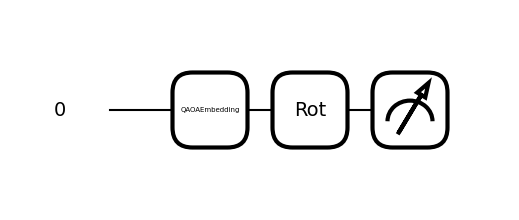

Embedding (1×1) Training:   0%|          | 0/70 [00:00<?, ?it/s]

Model (1×1) Training: 100%|██████████| 200/200 [00:44<00:00,  4.48it/s, loss=0.506593]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.340086             Mean squared error of prediction
                    R² Score                  -0.000053            Coefficient of determination
                    Training Time (s)         44.687736            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


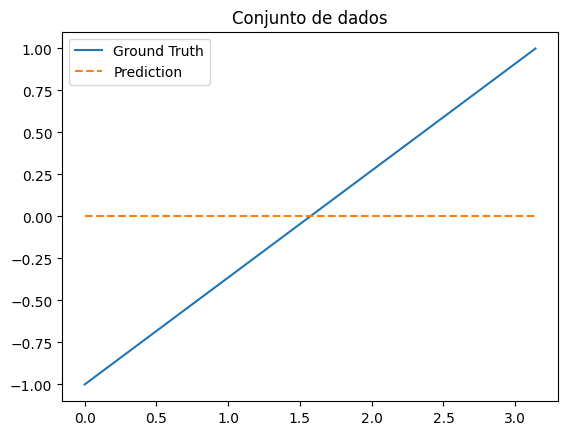

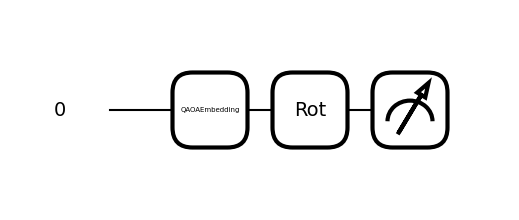

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.630930]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.495125             Mean squared error of prediction
                    R² Score                  -0.000001            Coefficient of determination
                    Training Time (s)         45.662359            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


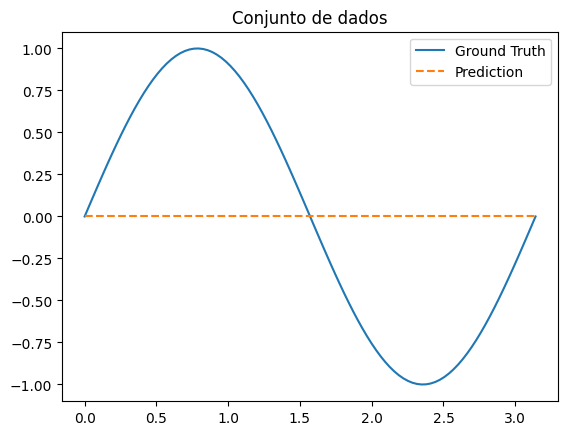

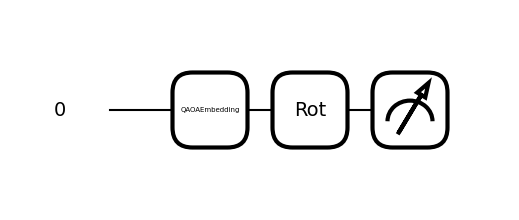

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.44it/s, loss=0.508411]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.392194             Mean squared error of prediction
                    R² Score                  -0.081156            Coefficient of determination
                    Training Time (s)         45.067003            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


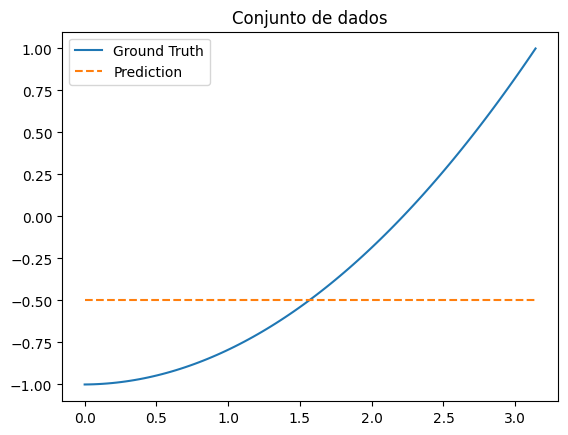

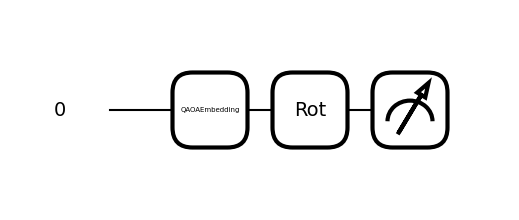

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.259697]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.143429             Mean squared error of prediction
                    R² Score                  -0.011676            Coefficient of determination
                    Training Time (s)         45.627357            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


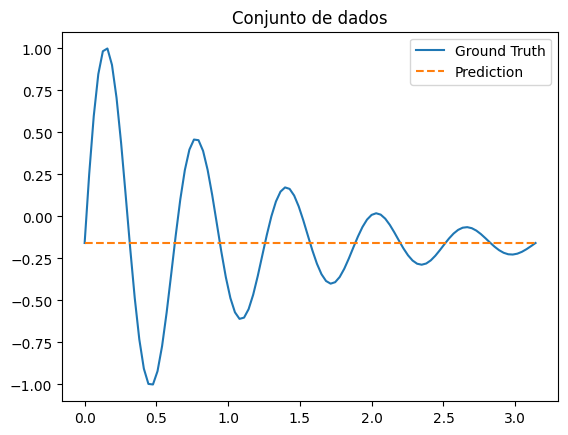

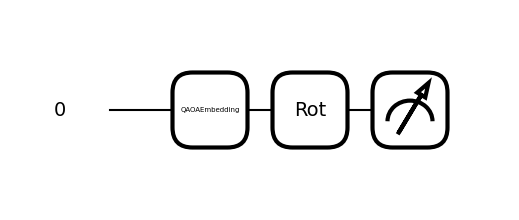

Model (1×1) Training: 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.243724]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.135318             Mean squared error of prediction
                    R² Score                  -0.093058            Coefficient of determination
                    Training Time (s)         44.715849            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


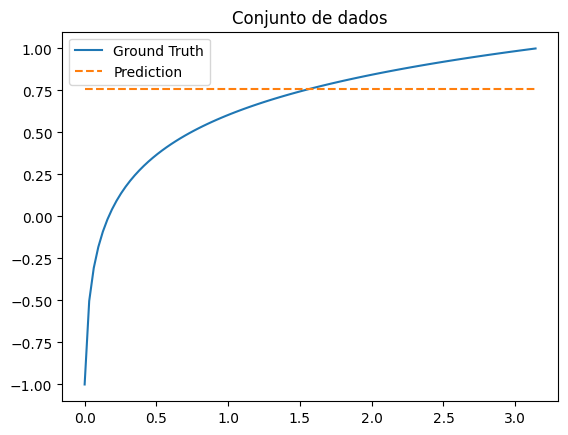

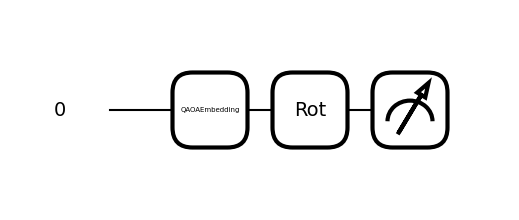

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.41it/s, loss=0.227642]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.260380             Mean squared error of prediction
                    R² Score                  -0.230171            Coefficient of determination
                    Training Time (s)         45.366761            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


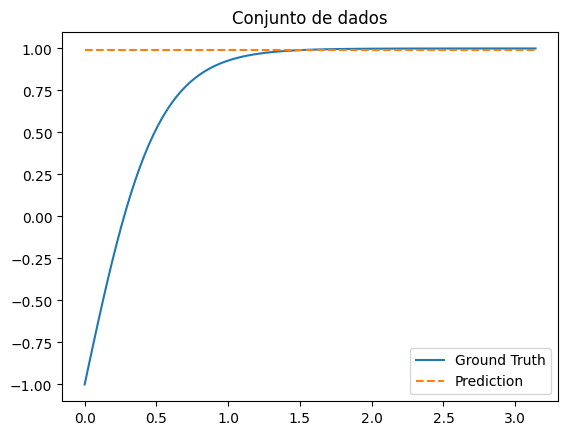

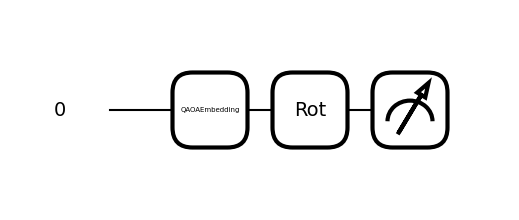

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.44it/s, loss=0.507844]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.340168             Mean squared error of prediction
                    R² Score                  -0.000296            Coefficient of determination
                    Training Time (s)         45.056571            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


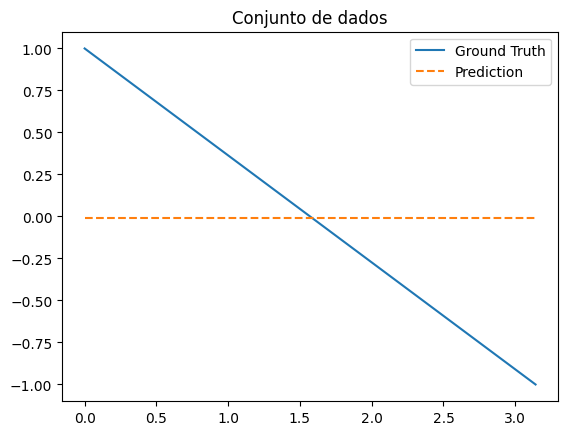

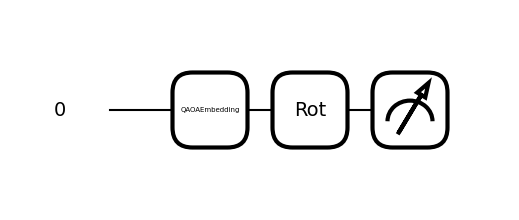

Model (1×1) Training: 100%|██████████| 200/200 [00:46<00:00,  4.29it/s, loss=0.517870]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.353408             Mean squared error of prediction
                    R² Score                  -0.000297            Coefficient of determination
                    Training Time (s)         46.611894            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


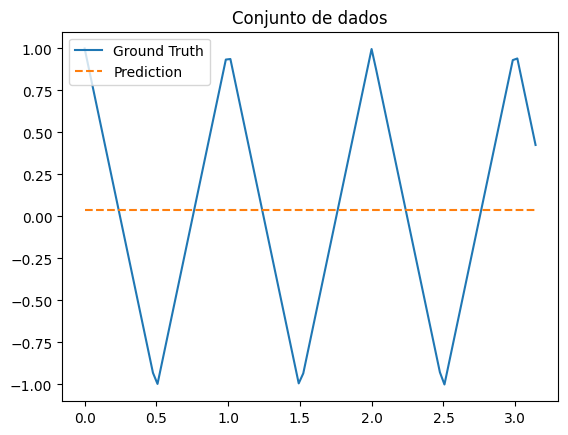

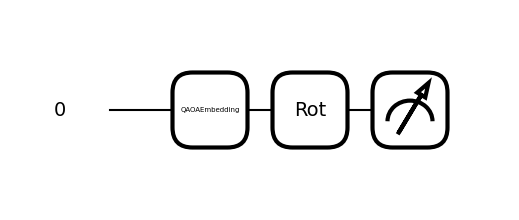

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.43it/s, loss=0.498107]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.332248             Mean squared error of prediction
                    R² Score                  -0.000212            Coefficient of determination
                    Training Time (s)         45.101601            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


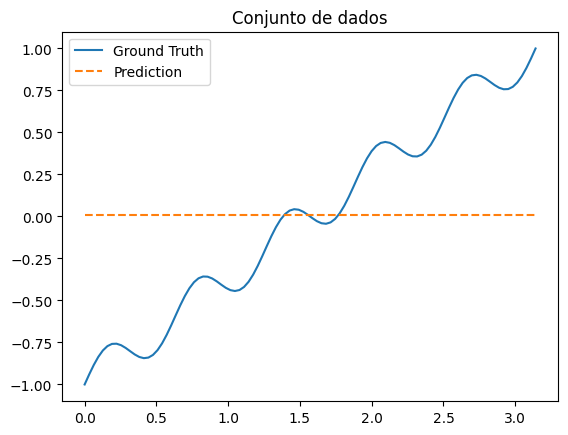

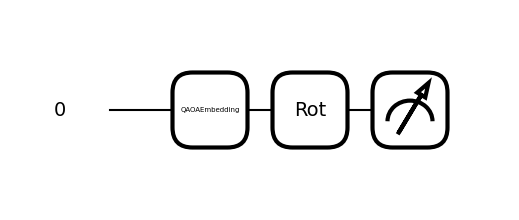

Model (1×1) Training: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s, loss=0.446787]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.393330             Mean squared error of prediction
                    R² Score                  -0.188737            Coefficient of determination
                    Training Time (s)         45.551386            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          1                    Required resources
                    Circuit Depth             2                    Generated circuit complexity
                    


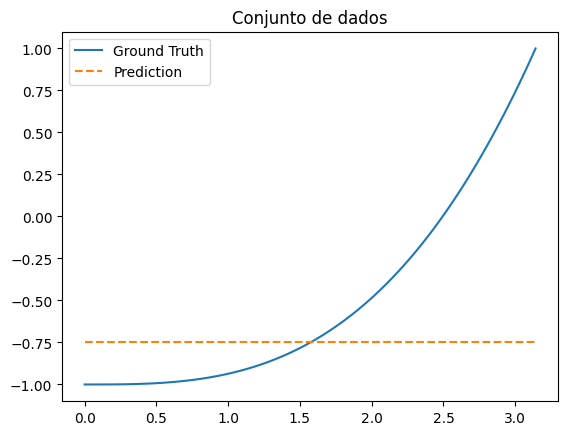

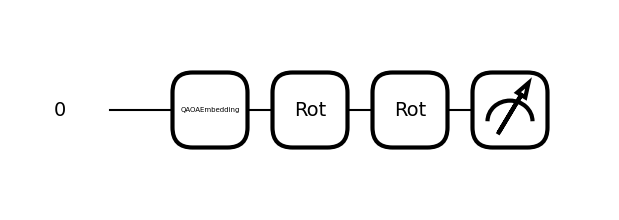

Model (1×2) Training: 100%|██████████| 200/200 [01:06<00:00,  3.02it/s, loss=0.303466]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.186481             Mean squared error of prediction
                    R² Score                  0.451635             Coefficient of determination
                    Training Time (s)         66.196294            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


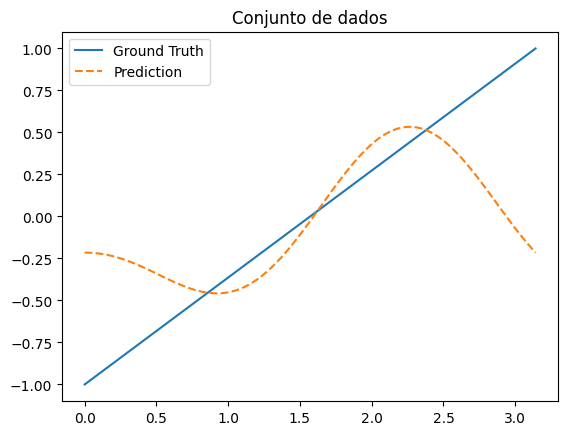

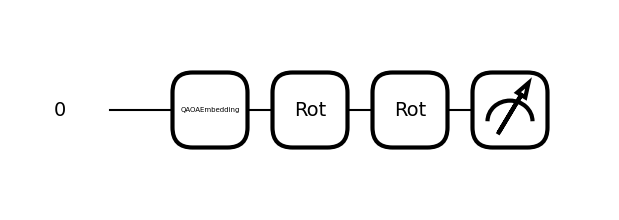

Model (1×2) Training: 100%|██████████| 200/200 [01:04<00:00,  3.11it/s, loss=0.271830]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.117320             Mean squared error of prediction
                    R² Score                  0.763049             Coefficient of determination
                    Training Time (s)         64.387602            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


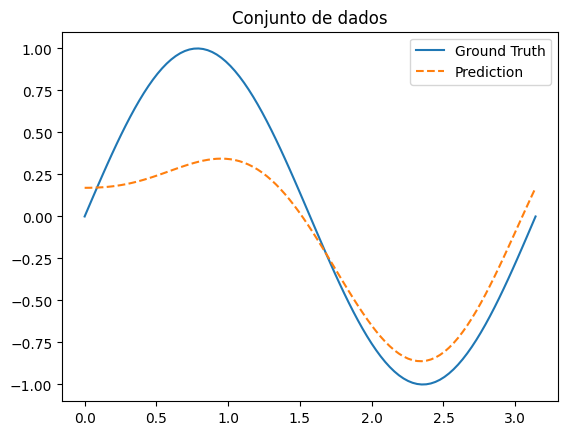

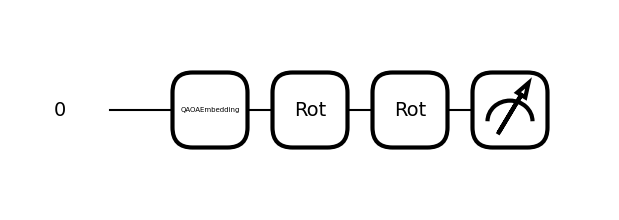

Model (1×2) Training: 100%|██████████| 200/200 [01:03<00:00,  3.14it/s, loss=0.297830]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.195816             Mean squared error of prediction
                    R² Score                  0.460195             Coefficient of determination
                    Training Time (s)         63.723987            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


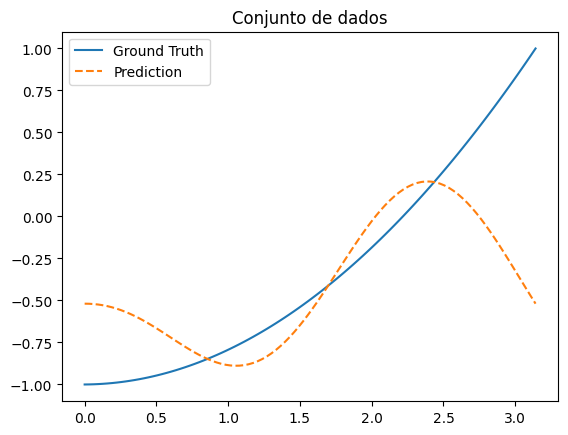

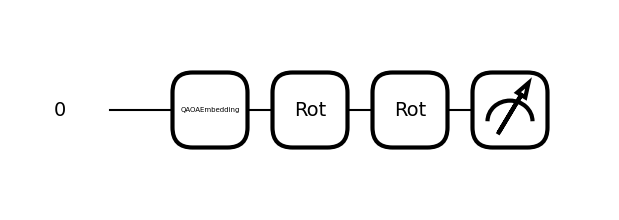

Model (1×2) Training: 100%|██████████| 200/200 [01:03<00:00,  3.14it/s, loss=0.271615]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.132995             Mean squared error of prediction
                    R² Score                  0.061923             Coefficient of determination
                    Training Time (s)         63.606959            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


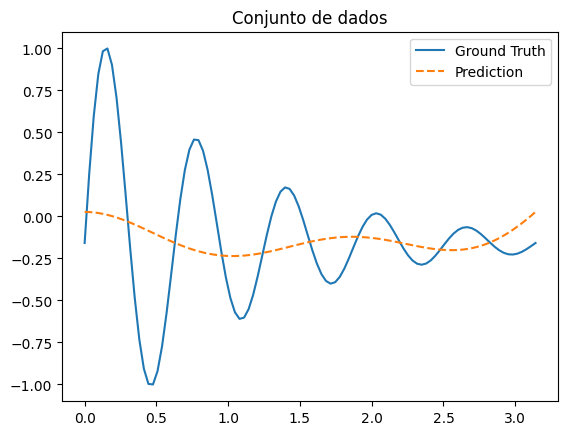

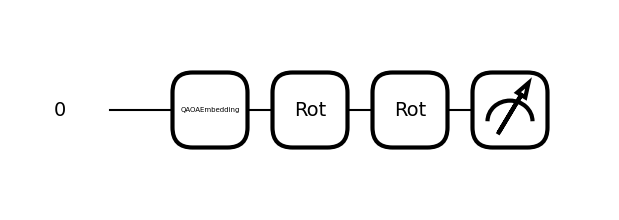

Model (1×2) Training: 100%|██████████| 200/200 [01:03<00:00,  3.15it/s, loss=0.142811]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.069296             Mean squared error of prediction
                    R² Score                  0.440247             Coefficient of determination
                    Training Time (s)         63.579951            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


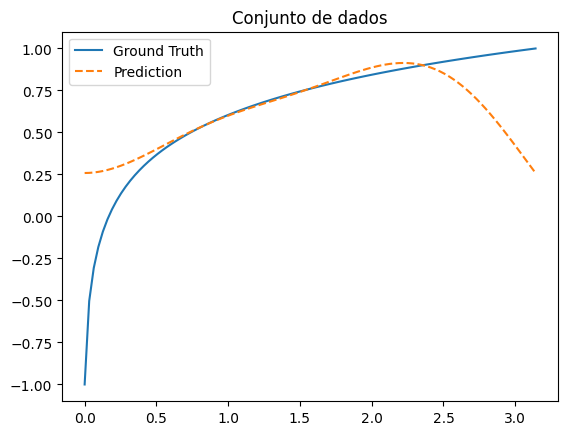

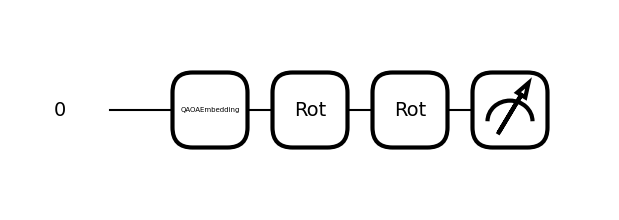

Model (1×2) Training: 100%|██████████| 200/200 [01:06<00:00,  3.00it/s, loss=0.182110]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.139428             Mean squared error of prediction
                    R² Score                  0.341269             Coefficient of determination
                    Training Time (s)         66.702953            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


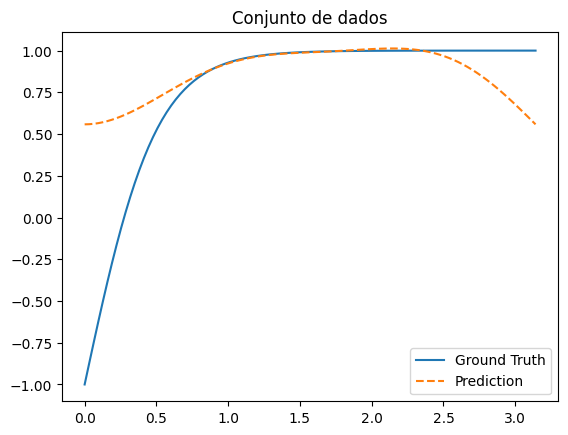

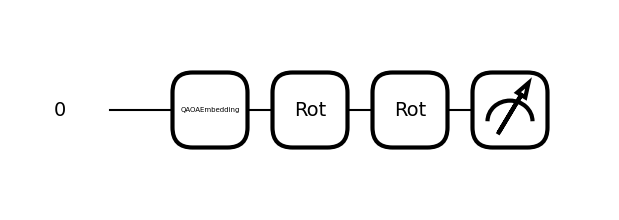

Model (1×2) Training: 100%|██████████| 200/200 [01:08<00:00,  2.90it/s, loss=0.352540]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.219020             Mean squared error of prediction
                    R² Score                  0.355950             Coefficient of determination
                    Training Time (s)         68.971688            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


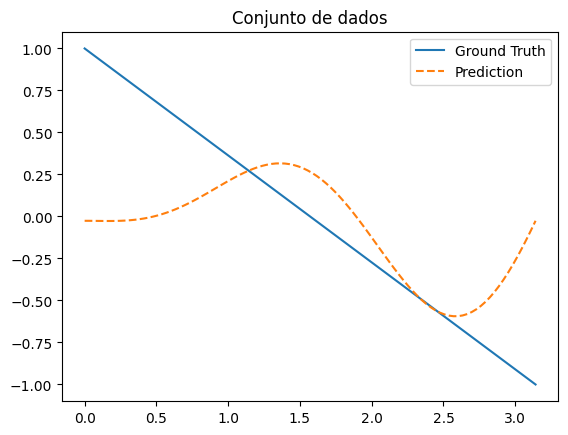

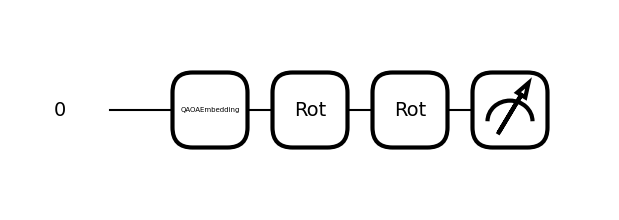

Model (1×2) Training: 100%|██████████| 200/200 [01:08<00:00,  2.90it/s, loss=0.513718]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.339929             Mean squared error of prediction
                    R² Score                  0.037854             Coefficient of determination
                    Training Time (s)         68.905298            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


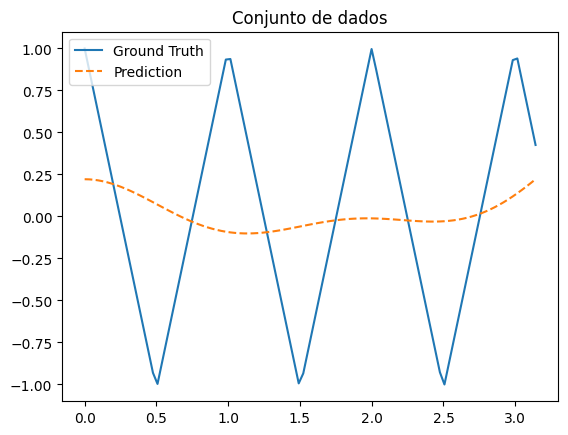

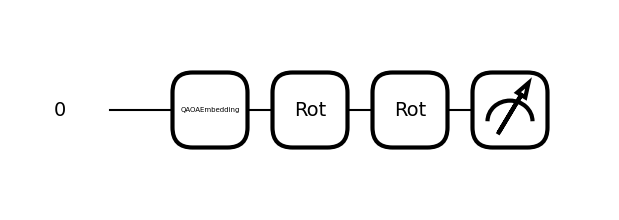

Model (1×2) Training: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s, loss=0.309084]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.175749             Mean squared error of prediction
                    R² Score                  0.470919             Coefficient of determination
                    Training Time (s)         71.593958            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


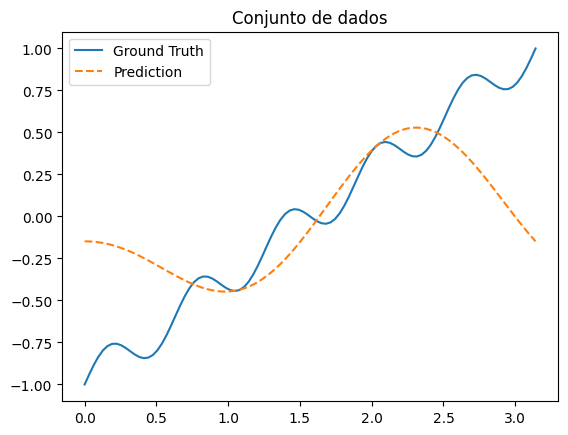

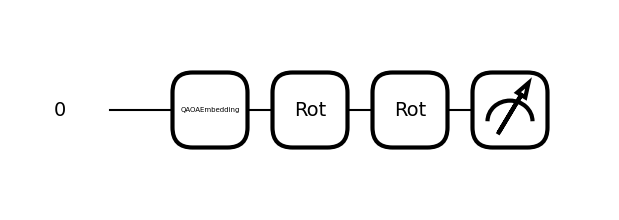

Model (1×2) Training: 100%|██████████| 200/200 [01:05<00:00,  3.06it/s, loss=0.294137]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.196608             Mean squared error of prediction
                    R² Score                  0.405803             Coefficient of determination
                    Training Time (s)         65.348727            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          2                    Required resources
                    Circuit Depth             3                    Generated circuit complexity
                    


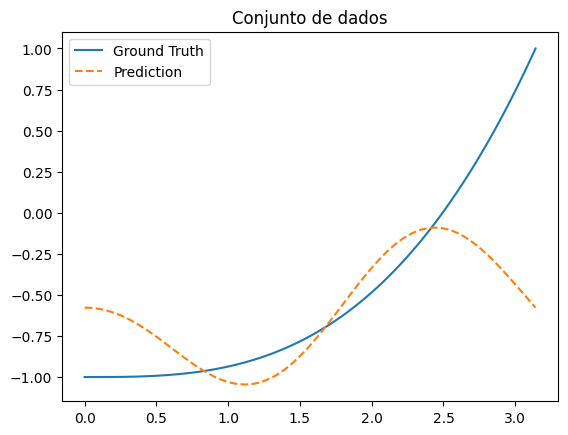

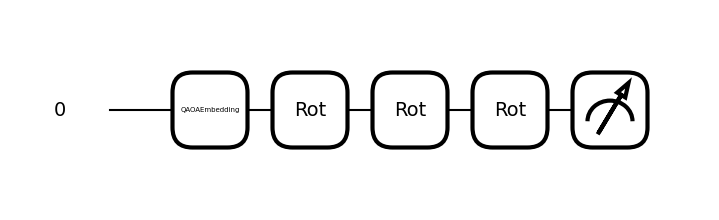

Model (1×3) Training: 100%|██████████| 200/200 [01:26<00:00,  2.30it/s, loss=0.496366]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.526749             Mean squared error of prediction
                    R² Score                  -0.548954            Coefficient of determination
                    Training Time (s)         86.791282            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


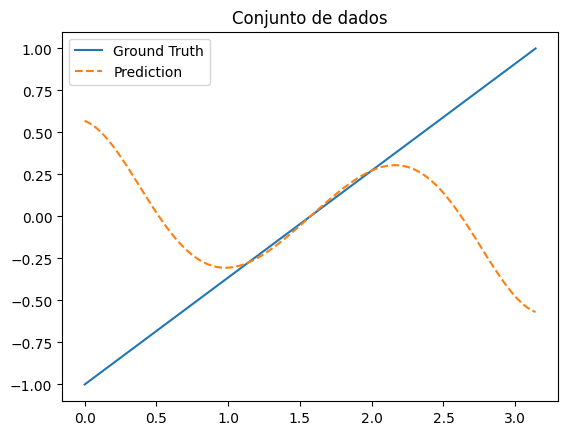

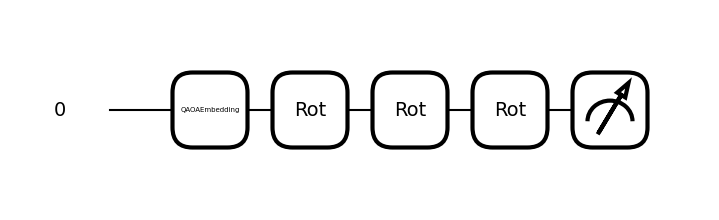

Model (1×3) Training: 100%|██████████| 200/200 [01:25<00:00,  2.33it/s, loss=0.465697]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.351736             Mean squared error of prediction
                    R² Score                  0.289600             Coefficient of determination
                    Training Time (s)         85.896319            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


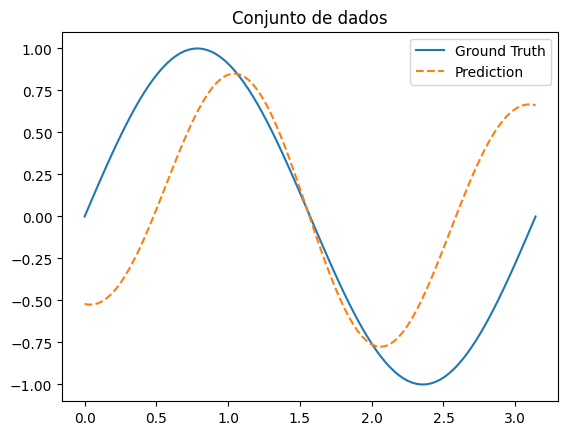

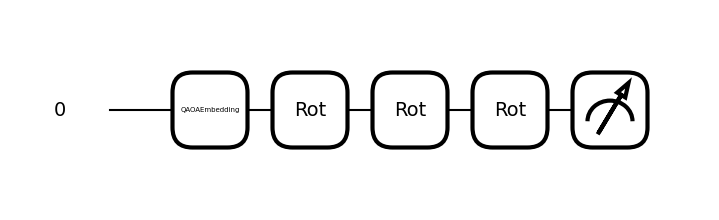

Model (1×3) Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s, loss=0.494648]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.556457             Mean squared error of prediction
                    R² Score                  -0.533978            Coefficient of determination
                    Training Time (s)         84.263140            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


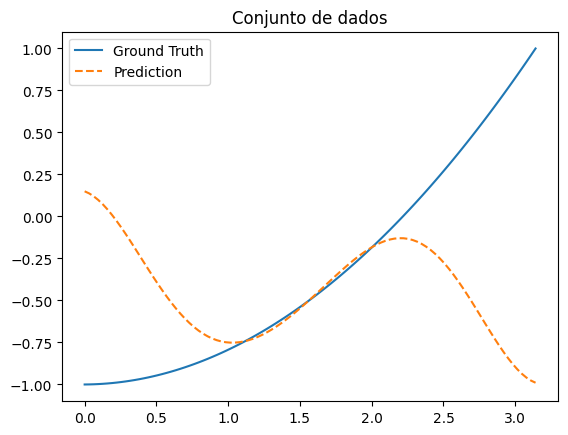

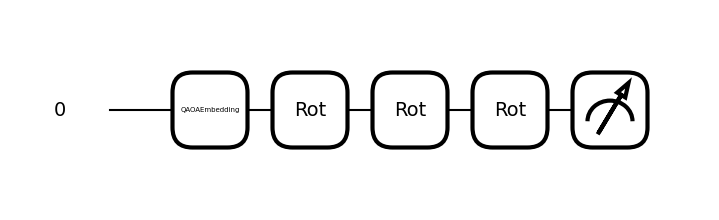

Model (1×3) Training: 100%|██████████| 200/200 [01:24<00:00,  2.35it/s, loss=0.259818]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.143386             Mean squared error of prediction
                    R² Score                  -0.011370            Coefficient of determination
                    Training Time (s)         84.996727            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


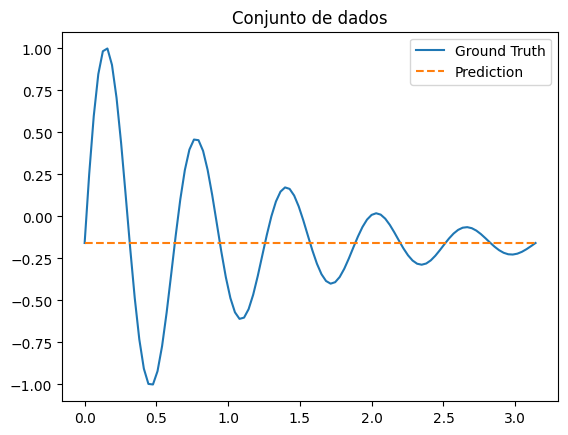

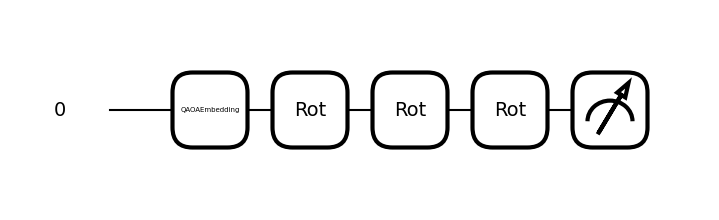

Model (1×3) Training: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s, loss=0.243829]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.134887             Mean squared error of prediction
                    R² Score                  -0.089576            Coefficient of determination
                    Training Time (s)         88.090078            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


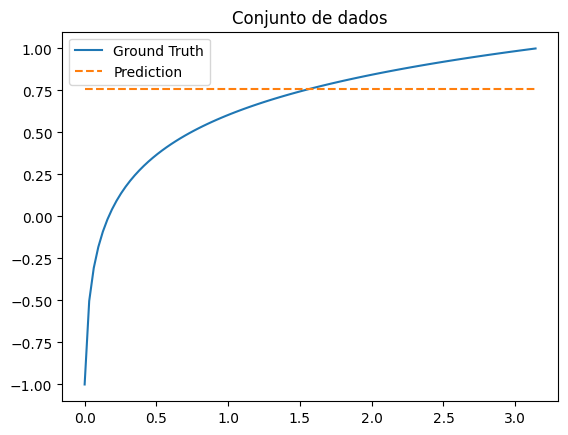

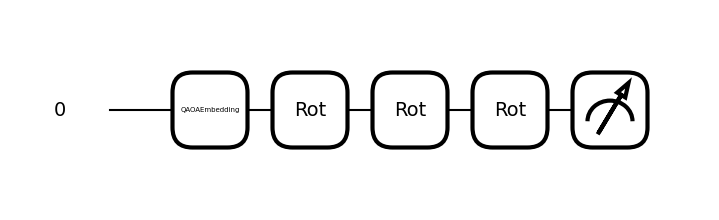

Model (1×3) Training: 100%|██████████| 200/200 [01:33<00:00,  2.13it/s, loss=0.227381]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.260404             Mean squared error of prediction
                    R² Score                  -0.230285            Coefficient of determination
                    Training Time (s)         93.738425            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


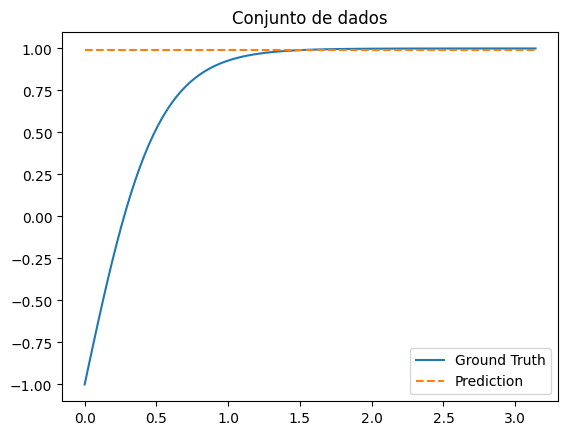

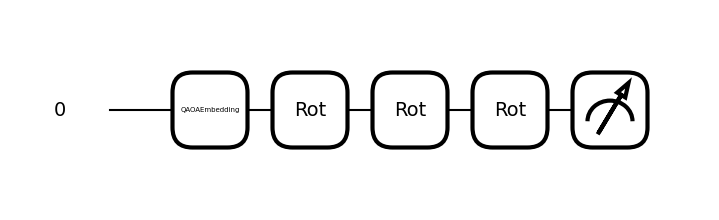

Model (1×3) Training: 100%|██████████| 200/200 [01:25<00:00,  2.33it/s, loss=0.511347]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.340129             Mean squared error of prediction
                    R² Score                  -0.000180            Coefficient of determination
                    Training Time (s)         85.665538            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


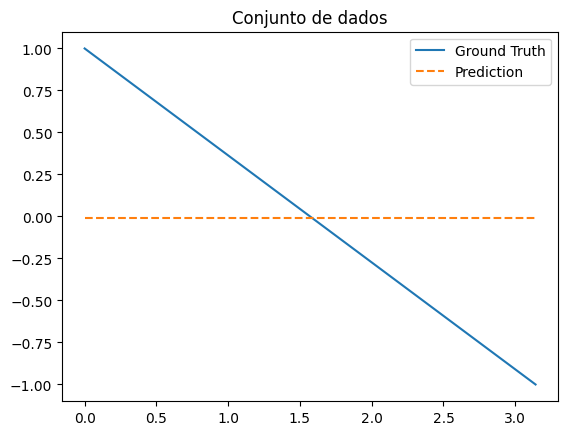

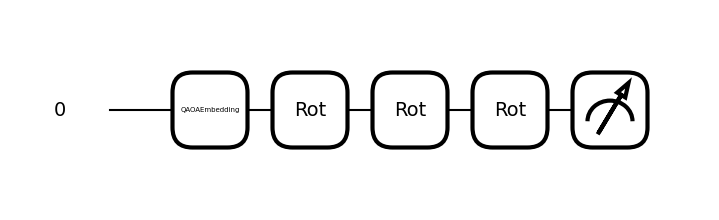

Model (1×3) Training: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s, loss=0.502154]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.352064             Mean squared error of prediction
                    R² Score                  0.003508             Coefficient of determination
                    Training Time (s)         85.210415            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


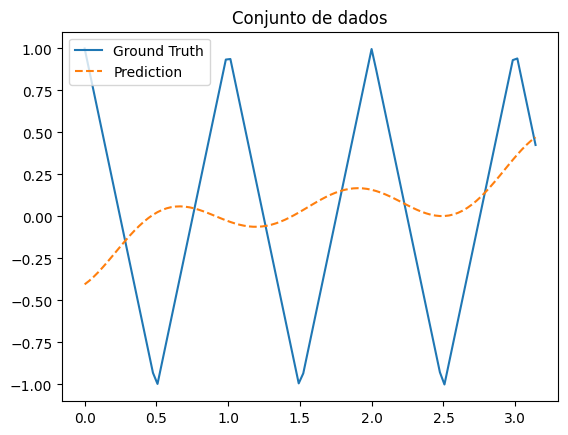

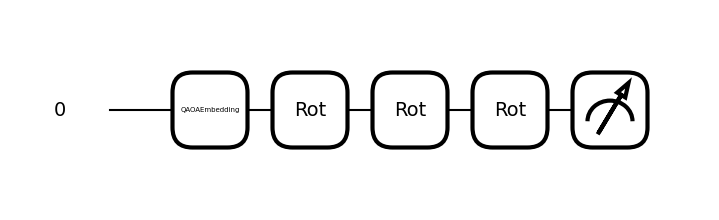

Model (1×3) Training: 100%|██████████| 200/200 [01:26<00:00,  2.31it/s, loss=0.505156]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.521696             Mean squared error of prediction
                    R² Score                  -0.570533            Coefficient of determination
                    Training Time (s)         86.424846            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


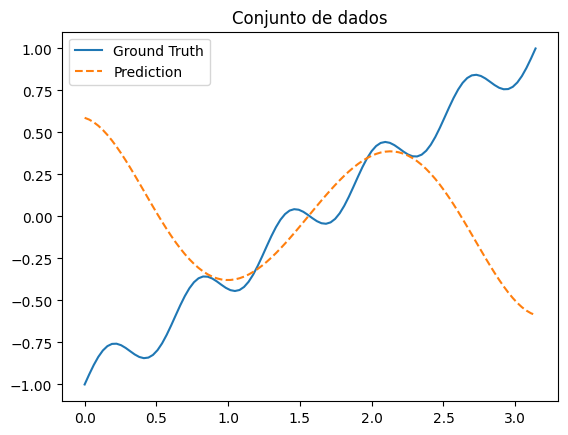

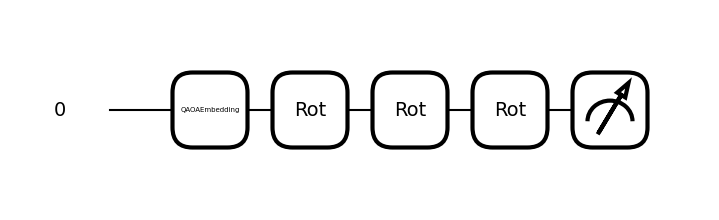

Model (1×3) Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s, loss=0.451534]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.392841             Mean squared error of prediction
                    R² Score                  -0.187261            Coefficient of determination
                    Training Time (s)         84.861189            Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          3                    Required resources
                    Circuit Depth             4                    Generated circuit complexity
                    


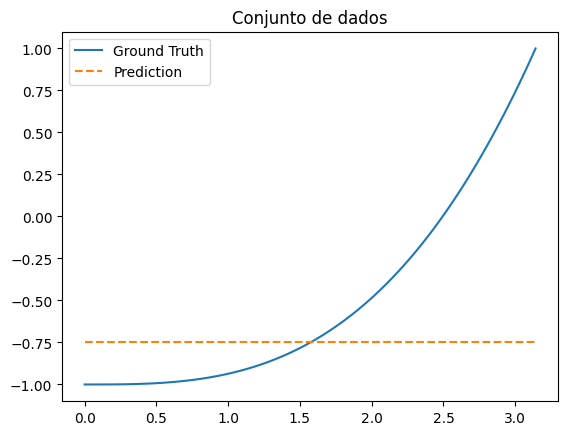

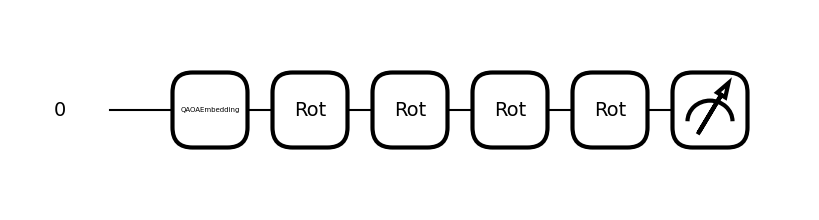

Model (1×4) Training: 100%|██████████| 200/200 [01:45<00:00,  1.90it/s, loss=0.505165]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.340068             Mean squared error of prediction
                    R² Score                  -0.000001            Coefficient of determination
                    Training Time (s)         105.190254           Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             5                    Generated circuit complexity
                    


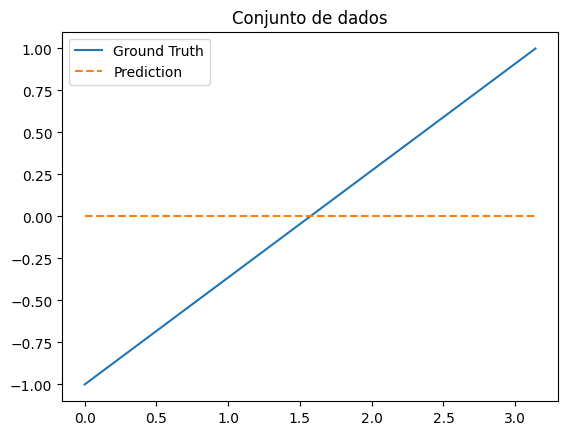

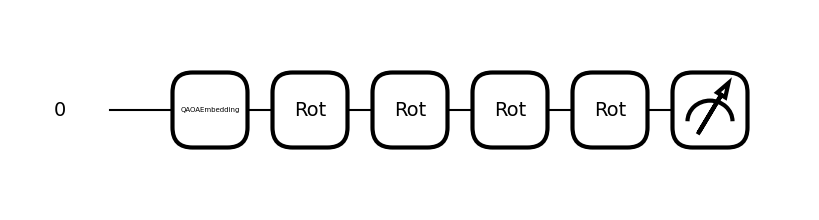

Model (1×4) Training: 100%|██████████| 200/200 [01:55<00:00,  1.73it/s, loss=0.635988]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.495125             Mean squared error of prediction
                    R² Score                  0.000000             Coefficient of determination
                    Training Time (s)         115.550862           Total training time
                    Number of Qubits          1                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             5                    Generated circuit complexity
                    


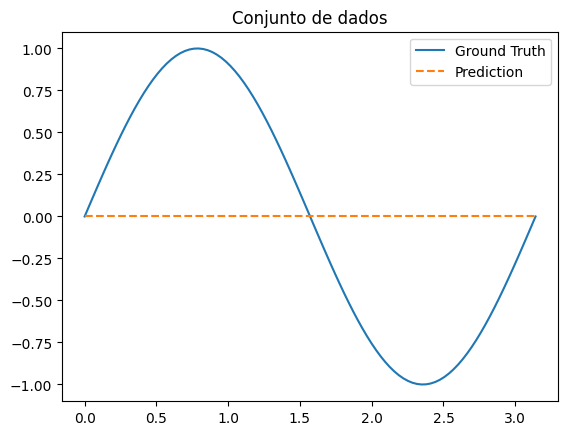

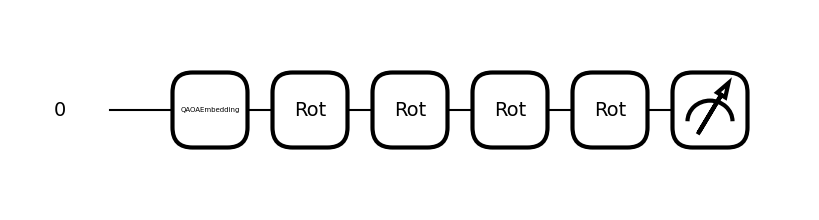

Embedding (1×4) Training:  40%|████      | 28/70 [00:19<00:29,  1.43it/s]


KeyboardInterrupt: 

In [39]:
N=6
result_list = []
for n_qubits in range(1,N):
    for n_layers in range(1,N):
        for i in range(len(datasets)):
            dataset = datasets[i]
            X = np.column_stack([dataset["x"], dataset["x"]**2,np.sin(dataset["x"]), dataset["x"], dataset["x"]])
            y = dataset["y"]
            X_original = dataset["x"].reshape(-1, 1)
            model = QuantumRegressor(n_qubits=n_qubits, n_layers=n_layers)
            model.plot_circuit()

            limitX = n_qubits if n_qubits < X.shape[1] else 3
            model.fit(X=X[:,:limitX],y=y,epochs=200)

            y_pred = model.predict(X[:,:limitX])

            results = model.stats(y_pred,y)
            result_list.append(results)
            write_csv(result_list)

            plt.title("Conjunto de dados")
            plt.plot(X_original, y, label="Ground Truth")
            plt.plot(X_original, y_pred, '--', label="Prediction")
            plt.legend()
            plt.show()